In [1]:
# import system libs
import os
from glob import glob

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from UNet0 import UNet
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import cv2
# import pandas as pd
# import numpy as np
from utils import  create_dataloader, dice_loss, dice_coef, iou_coef
from torch.utils.tensorboard import SummaryWriter
# import data handling tools
import cv2
import numpy as np
import pandas as pd
# import seaborn as sns
# %matplotlib inline
# from skimage.color import rgb2gray
# from skimage.morphology import label
# from skimage.transform import resize
# from skimage.io import imread, imshow, concatenate_images
# sns.set_style('darkgrid')

%reload_ext autoreload
%autoreload 2

In [2]:
def create_df(data_dir):
    images_paths = []
    masks_paths = sorted(glob(f'{data_dir}/*/*_mask*'))

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [3]:
data_dir = '/workspaces/data/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

In [4]:
len(train_df), len(valid_df), len(test_df)

(3143, 393, 393)

In [5]:
# %load_ext autoreload
# %autoreload 2
#from utils import create_dataloader
BATCH_SIZE = 8
train_loader = create_dataloader(train_df, batch_size=BATCH_SIZE, augment=True, num_workers=16)
valid_loader = create_dataloader(valid_df, batch_size=BATCH_SIZE, augment=False, num_workers=16)
test_loader = create_dataloader(test_df, batch_size=BATCH_SIZE, augment=False, num_workers=16)


/home/vscode/.local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


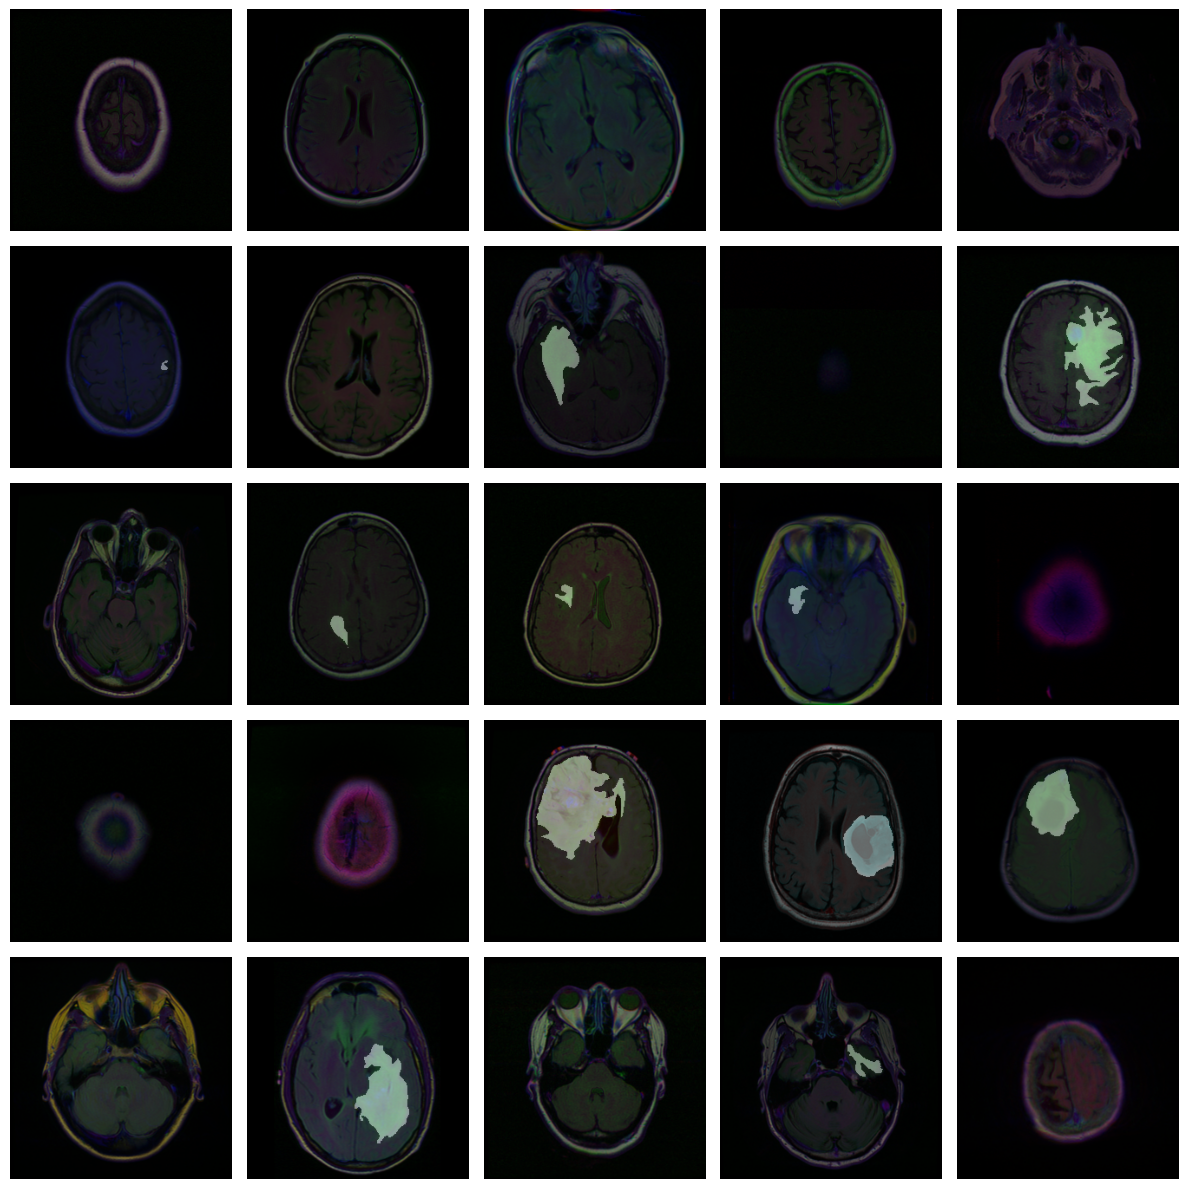

In [6]:
from utils import show_images
show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.001)
criterion = dice_loss  # al

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    for images, masks in tqdm(dataloader, desc='Training'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)#round2: should be sigmoid activation
        # outputs = torch.sigmoid(outputs)  ## Not needed
        loss = criterion(masks, outputs,smooth=1)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coef(masks, outputs,smooth=1).item()
        total_iou += iou_coef(masks, outputs,smooth=1).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n



def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validating'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(masks, outputs,smooth=1)
            total_loss += loss.item()
            total_dice += dice_coef(masks, outputs,smooth=1).item()
            total_iou += iou_coef(masks, outputs,smooth=1).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n


In [8]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 1, 256, 256]          --
├─ConvBlock: 1-1                         [8, 64, 256, 256]         --
│    └─Sequential: 2-1                   [8, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [8, 64, 256, 256]         1,792
│    │    └─ReLU: 3-2                    [8, 64, 256, 256]         --
│    │    └─Conv2d: 3-3                  [8, 64, 256, 256]         36,928
│    │    └─BatchNorm2d: 3-4             [8, 64, 256, 256]         128
│    │    └─ReLU: 3-5                    [8, 64, 256, 256]         --
├─MaxPool2d: 1-2                         [8, 64, 128, 128]         --
├─ConvBlock: 1-3                         [8, 128, 128, 128]        --
│    └─Sequential: 2-2                   [8, 128, 128, 128]        --
│    │    └─Conv2d: 3-6                  [8, 128, 128, 128]        73,856
│    │    └─ReLU: 3-7                    [8, 128, 128, 128]        --
│  

In [9]:
# import os
import datetime

epochs = 120
best_val_loss = float('inf')
save_path = 'unet1.pth'

log_dir = os.path.join("/workspaces/data/MegaGen/UNet", 
                       "unet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
}



In [10]:
print ("device:",next(model.parameters()).device)
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_dice, val_iou = validate(model, valid_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} → {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)

    # Log to TensorBoard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Val", val_loss, epoch)
    writer.add_scalar("Dice/Train", train_dice, epoch)
    writer.add_scalar("Dice/Val", val_dice, epoch)
    writer.add_scalar("IoU/Train", train_iou, epoch)
    writer.add_scalar("IoU/Val", val_iou, epoch)

    # Save to history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)


device: cuda:0

Epoch 1/120


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Validating: 100%|██████████| 50/50 [00:06<00:00,  7.20it/s]


Train Loss: -0.1806, Dice: 0.1806, IoU: 0.1089
Val   Loss: -0.3386, Dice: 0.3386, IoU: 0.2303
Validation loss improved (inf → -0.3386). Saving model...

Epoch 2/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.66it/s]


Train Loss: -0.5188, Dice: 0.5188, IoU: 0.3861
Val   Loss: -0.5633, Dice: 0.5633, IoU: 0.4261
Validation loss improved (-0.3386 → -0.5633). Saving model...

Epoch 3/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.60it/s]


Train Loss: -0.6011, Dice: 0.6011, IoU: 0.4675
Val   Loss: -0.6237, Dice: 0.6237, IoU: 0.4889
Validation loss improved (-0.5633 → -0.6237). Saving model...

Epoch 4/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]


Train Loss: -0.5798, Dice: 0.5798, IoU: 0.4529
Val   Loss: -0.6154, Dice: 0.6154, IoU: 0.4960

Epoch 5/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


Train Loss: -0.6086, Dice: 0.6086, IoU: 0.4795
Val   Loss: -0.6828, Dice: 0.6828, IoU: 0.5488
Validation loss improved (-0.6237 → -0.6828). Saving model...

Epoch 6/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.63it/s]


Train Loss: -0.6142, Dice: 0.6142, IoU: 0.4852
Val   Loss: -0.6540, Dice: 0.6540, IoU: 0.5166

Epoch 7/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.60it/s]


Train Loss: -0.6280, Dice: 0.6280, IoU: 0.5006
Val   Loss: -0.6128, Dice: 0.6128, IoU: 0.4791

Epoch 8/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.61it/s]


Train Loss: -0.6261, Dice: 0.6261, IoU: 0.4972
Val   Loss: -0.6719, Dice: 0.6719, IoU: 0.5405

Epoch 9/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]


Train Loss: -0.6473, Dice: 0.6473, IoU: 0.5191
Val   Loss: -0.7273, Dice: 0.7273, IoU: 0.6087
Validation loss improved (-0.6828 → -0.7273). Saving model...

Epoch 10/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.26it/s]


Train Loss: -0.6575, Dice: 0.6575, IoU: 0.5305
Val   Loss: -0.6487, Dice: 0.6487, IoU: 0.5225

Epoch 11/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


Train Loss: -0.6427, Dice: 0.6427, IoU: 0.5177
Val   Loss: -0.5484, Dice: 0.5484, IoU: 0.4394

Epoch 12/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]


Train Loss: -0.6588, Dice: 0.6588, IoU: 0.5323
Val   Loss: -0.6552, Dice: 0.6552, IoU: 0.5371

Epoch 13/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


Train Loss: -0.6566, Dice: 0.6566, IoU: 0.5294
Val   Loss: -0.6905, Dice: 0.6905, IoU: 0.5714

Epoch 14/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Train Loss: -0.6700, Dice: 0.6700, IoU: 0.5447
Val   Loss: -0.6950, Dice: 0.6950, IoU: 0.5770

Epoch 15/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.32it/s]


Train Loss: -0.6653, Dice: 0.6653, IoU: 0.5429
Val   Loss: -0.7272, Dice: 0.7272, IoU: 0.5991

Epoch 16/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]


Train Loss: -0.6836, Dice: 0.6836, IoU: 0.5567
Val   Loss: -0.7215, Dice: 0.7215, IoU: 0.5942

Epoch 17/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


Train Loss: -0.6795, Dice: 0.6795, IoU: 0.5585
Val   Loss: -0.7353, Dice: 0.7353, IoU: 0.6194
Validation loss improved (-0.7273 → -0.7353). Saving model...

Epoch 18/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.57it/s]


Train Loss: -0.6652, Dice: 0.6652, IoU: 0.5427
Val   Loss: -0.5897, Dice: 0.5897, IoU: 0.4762

Epoch 19/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.59it/s]


Train Loss: -0.6719, Dice: 0.6719, IoU: 0.5524
Val   Loss: -0.6540, Dice: 0.6540, IoU: 0.5502

Epoch 20/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.31it/s]


Train Loss: -0.6681, Dice: 0.6681, IoU: 0.5443
Val   Loss: -0.7263, Dice: 0.7263, IoU: 0.6124

Epoch 21/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.41it/s]


Train Loss: -0.6765, Dice: 0.6765, IoU: 0.5559
Val   Loss: -0.7356, Dice: 0.7356, IoU: 0.6155
Validation loss improved (-0.7353 → -0.7356). Saving model...

Epoch 22/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]


Train Loss: -0.6750, Dice: 0.6750, IoU: 0.5506
Val   Loss: -0.7166, Dice: 0.7166, IoU: 0.5954

Epoch 23/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


Train Loss: -0.7009, Dice: 0.7009, IoU: 0.5800
Val   Loss: -0.7469, Dice: 0.7469, IoU: 0.6256
Validation loss improved (-0.7356 → -0.7469). Saving model...

Epoch 24/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


Train Loss: -0.6862, Dice: 0.6862, IoU: 0.5687
Val   Loss: -0.7515, Dice: 0.7515, IoU: 0.6396
Validation loss improved (-0.7469 → -0.7515). Saving model...

Epoch 25/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


Train Loss: -0.6894, Dice: 0.6894, IoU: 0.5709
Val   Loss: -0.7346, Dice: 0.7346, IoU: 0.6253

Epoch 26/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.35it/s]


Train Loss: -0.6841, Dice: 0.6841, IoU: 0.5644
Val   Loss: -0.7559, Dice: 0.7559, IoU: 0.6398
Validation loss improved (-0.7515 → -0.7559). Saving model...

Epoch 27/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


Train Loss: -0.6915, Dice: 0.6915, IoU: 0.5711
Val   Loss: -0.7368, Dice: 0.7368, IoU: 0.6220

Epoch 28/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


Train Loss: -0.7071, Dice: 0.7071, IoU: 0.5862
Val   Loss: -0.7624, Dice: 0.7624, IoU: 0.6488
Validation loss improved (-0.7559 → -0.7624). Saving model...

Epoch 29/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]


Train Loss: -0.6964, Dice: 0.6964, IoU: 0.5740
Val   Loss: -0.7366, Dice: 0.7366, IoU: 0.6287

Epoch 30/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.34it/s]


Train Loss: -0.7045, Dice: 0.7045, IoU: 0.5818
Val   Loss: -0.7459, Dice: 0.7459, IoU: 0.6277

Epoch 31/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]


Train Loss: -0.6949, Dice: 0.6949, IoU: 0.5731
Val   Loss: -0.7397, Dice: 0.7397, IoU: 0.6349

Epoch 32/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.59it/s]


Train Loss: -0.7096, Dice: 0.7096, IoU: 0.5869
Val   Loss: -0.7566, Dice: 0.7566, IoU: 0.6470

Epoch 33/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]


Train Loss: -0.6837, Dice: 0.6837, IoU: 0.5651
Val   Loss: -0.7490, Dice: 0.7490, IoU: 0.6403

Epoch 34/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


Train Loss: -0.7156, Dice: 0.7156, IoU: 0.5975
Val   Loss: -0.7450, Dice: 0.7450, IoU: 0.6273

Epoch 35/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]


Train Loss: -0.6901, Dice: 0.6901, IoU: 0.5745
Val   Loss: -0.7634, Dice: 0.7634, IoU: 0.6504
Validation loss improved (-0.7624 → -0.7634). Saving model...

Epoch 36/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.46it/s]


Train Loss: -0.7167, Dice: 0.7167, IoU: 0.5972
Val   Loss: -0.7481, Dice: 0.7481, IoU: 0.6450

Epoch 37/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.52it/s]


Train Loss: -0.7301, Dice: 0.7301, IoU: 0.6115
Val   Loss: -0.7913, Dice: 0.7913, IoU: 0.6746
Validation loss improved (-0.7634 → -0.7913). Saving model...

Epoch 38/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


Train Loss: -0.6993, Dice: 0.6993, IoU: 0.5844
Val   Loss: -0.7782, Dice: 0.7782, IoU: 0.6651

Epoch 39/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


Train Loss: -0.7460, Dice: 0.7460, IoU: 0.6262
Val   Loss: -0.7407, Dice: 0.7407, IoU: 0.6276

Epoch 40/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.38it/s]


Train Loss: -0.7089, Dice: 0.7089, IoU: 0.5919
Val   Loss: -0.7993, Dice: 0.7993, IoU: 0.6896
Validation loss improved (-0.7913 → -0.7993). Saving model...

Epoch 41/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]


Train Loss: -0.7300, Dice: 0.7300, IoU: 0.6158
Val   Loss: -0.7803, Dice: 0.7803, IoU: 0.6607

Epoch 42/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Train Loss: -0.7217, Dice: 0.7217, IoU: 0.6046
Val   Loss: -0.6992, Dice: 0.6992, IoU: 0.5746

Epoch 43/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


Train Loss: -0.7254, Dice: 0.7254, IoU: 0.6077
Val   Loss: -0.7623, Dice: 0.7623, IoU: 0.6567

Epoch 44/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.65it/s]


Train Loss: -0.7045, Dice: 0.7045, IoU: 0.5872
Val   Loss: -0.7741, Dice: 0.7741, IoU: 0.6485

Epoch 45/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.14it/s]


Train Loss: -0.7295, Dice: 0.7295, IoU: 0.6125
Val   Loss: -0.7749, Dice: 0.7749, IoU: 0.6584

Epoch 46/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Train Loss: -0.7341, Dice: 0.7341, IoU: 0.6181
Val   Loss: -0.7614, Dice: 0.7614, IoU: 0.6553

Epoch 47/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.33it/s]


Train Loss: -0.7286, Dice: 0.7286, IoU: 0.6109
Val   Loss: -0.7864, Dice: 0.7864, IoU: 0.6847

Epoch 48/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Train Loss: -0.7364, Dice: 0.7364, IoU: 0.6257
Val   Loss: -0.8000, Dice: 0.8000, IoU: 0.6867
Validation loss improved (-0.7993 → -0.8000). Saving model...

Epoch 49/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]


Train Loss: -0.7327, Dice: 0.7327, IoU: 0.6186
Val   Loss: -0.7991, Dice: 0.7991, IoU: 0.6928

Epoch 50/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.29it/s]


Train Loss: -0.7616, Dice: 0.7616, IoU: 0.6451
Val   Loss: -0.8185, Dice: 0.8185, IoU: 0.7129
Validation loss improved (-0.8000 → -0.8185). Saving model...

Epoch 51/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


Train Loss: -0.7073, Dice: 0.7073, IoU: 0.5931
Val   Loss: -0.8094, Dice: 0.8094, IoU: 0.7078

Epoch 52/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.73it/s]


Train Loss: -0.6834, Dice: 0.6834, IoU: 0.5707
Val   Loss: -0.7942, Dice: 0.7942, IoU: 0.6807

Epoch 53/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.31it/s]


Train Loss: -0.7080, Dice: 0.7080, IoU: 0.5880
Val   Loss: -0.7158, Dice: 0.7158, IoU: 0.6058

Epoch 54/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.34it/s]


Train Loss: -0.7398, Dice: 0.7398, IoU: 0.6246
Val   Loss: -0.7880, Dice: 0.7880, IoU: 0.6784

Epoch 55/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.40it/s]


Train Loss: -0.7061, Dice: 0.7061, IoU: 0.5931
Val   Loss: -0.7310, Dice: 0.7310, IoU: 0.6196

Epoch 56/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.42it/s]


Train Loss: -0.7336, Dice: 0.7336, IoU: 0.6140
Val   Loss: -0.7517, Dice: 0.7517, IoU: 0.6338

Epoch 57/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.39it/s]


Train Loss: -0.7416, Dice: 0.7416, IoU: 0.6253
Val   Loss: -0.7592, Dice: 0.7592, IoU: 0.6496

Epoch 58/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.34it/s]


Train Loss: -0.7525, Dice: 0.7525, IoU: 0.6427
Val   Loss: -0.7867, Dice: 0.7867, IoU: 0.6818

Epoch 59/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.46it/s]


Train Loss: -0.7548, Dice: 0.7548, IoU: 0.6411
Val   Loss: -0.8137, Dice: 0.8137, IoU: 0.7034

Epoch 60/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s]


Train Loss: -0.7146, Dice: 0.7146, IoU: 0.5984
Val   Loss: -0.7730, Dice: 0.7730, IoU: 0.6564

Epoch 61/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.52it/s]


Train Loss: -0.7230, Dice: 0.7230, IoU: 0.6091
Val   Loss: -0.7397, Dice: 0.7397, IoU: 0.6198

Epoch 62/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.67it/s]


Train Loss: -0.7422, Dice: 0.7422, IoU: 0.6284
Val   Loss: -0.7951, Dice: 0.7951, IoU: 0.6884

Epoch 63/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.26it/s]


Train Loss: -0.7652, Dice: 0.7652, IoU: 0.6508
Val   Loss: -0.7939, Dice: 0.7939, IoU: 0.6856

Epoch 64/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Train Loss: -0.7490, Dice: 0.7490, IoU: 0.6374
Val   Loss: -0.7805, Dice: 0.7805, IoU: 0.6732

Epoch 65/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.32it/s]


Train Loss: -0.7410, Dice: 0.7410, IoU: 0.6241
Val   Loss: -0.7532, Dice: 0.7532, IoU: 0.6308

Epoch 66/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.35it/s]


Train Loss: -0.6946, Dice: 0.6946, IoU: 0.5816
Val   Loss: -0.6377, Dice: 0.6377, IoU: 0.5289

Epoch 67/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Train Loss: -0.7297, Dice: 0.7297, IoU: 0.6103
Val   Loss: -0.7827, Dice: 0.7827, IoU: 0.6704

Epoch 68/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.38it/s]


Train Loss: -0.7699, Dice: 0.7699, IoU: 0.6558
Val   Loss: -0.8100, Dice: 0.8100, IoU: 0.7080

Epoch 69/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


Train Loss: -0.7370, Dice: 0.7370, IoU: 0.6221
Val   Loss: -0.7969, Dice: 0.7969, IoU: 0.6909

Epoch 70/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


Train Loss: -0.7403, Dice: 0.7403, IoU: 0.6263
Val   Loss: -0.7840, Dice: 0.7840, IoU: 0.6637

Epoch 71/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.71it/s]


Train Loss: -0.7498, Dice: 0.7498, IoU: 0.6339
Val   Loss: -0.7333, Dice: 0.7333, IoU: 0.6190

Epoch 72/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.71it/s]


Train Loss: -0.7387, Dice: 0.7387, IoU: 0.6250
Val   Loss: -0.6885, Dice: 0.6885, IoU: 0.5791

Epoch 73/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Train Loss: -0.7468, Dice: 0.7468, IoU: 0.6322
Val   Loss: -0.7907, Dice: 0.7907, IoU: 0.6809

Epoch 74/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.40it/s]


Train Loss: -0.7522, Dice: 0.7522, IoU: 0.6370
Val   Loss: -0.7994, Dice: 0.7994, IoU: 0.6865

Epoch 75/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


Train Loss: -0.7580, Dice: 0.7580, IoU: 0.6456
Val   Loss: -0.7643, Dice: 0.7643, IoU: 0.6619

Epoch 76/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.25it/s]


Train Loss: -0.7726, Dice: 0.7726, IoU: 0.6578
Val   Loss: -0.8243, Dice: 0.8243, IoU: 0.7210
Validation loss improved (-0.8185 → -0.8243). Saving model...

Epoch 77/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.28it/s]


Train Loss: -0.7491, Dice: 0.7491, IoU: 0.6313
Val   Loss: -0.7952, Dice: 0.7952, IoU: 0.6863

Epoch 78/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.42it/s]


Train Loss: -0.7507, Dice: 0.7507, IoU: 0.6400
Val   Loss: -0.7226, Dice: 0.7226, IoU: 0.6152

Epoch 79/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.36it/s]


Train Loss: -0.7315, Dice: 0.7315, IoU: 0.6220
Val   Loss: -0.6549, Dice: 0.6549, IoU: 0.5321

Epoch 80/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.47it/s]


Train Loss: -0.7385, Dice: 0.7385, IoU: 0.6292
Val   Loss: -0.7567, Dice: 0.7567, IoU: 0.6526

Epoch 81/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.97it/s]


Train Loss: -0.7705, Dice: 0.7705, IoU: 0.6582
Val   Loss: -0.7684, Dice: 0.7684, IoU: 0.6628

Epoch 82/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.35it/s]


Train Loss: -0.7607, Dice: 0.7607, IoU: 0.6476
Val   Loss: -0.8029, Dice: 0.8029, IoU: 0.6881

Epoch 83/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.32it/s]


Train Loss: -0.7537, Dice: 0.7537, IoU: 0.6431
Val   Loss: -0.7848, Dice: 0.7848, IoU: 0.6839

Epoch 84/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.39it/s]


Train Loss: -0.7359, Dice: 0.7359, IoU: 0.6217
Val   Loss: -0.8132, Dice: 0.8132, IoU: 0.7051

Epoch 85/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


Train Loss: -0.7728, Dice: 0.7728, IoU: 0.6618
Val   Loss: -0.8315, Dice: 0.8315, IoU: 0.7250
Validation loss improved (-0.8243 → -0.8315). Saving model...

Epoch 86/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.25it/s]


Train Loss: -0.7626, Dice: 0.7626, IoU: 0.6557
Val   Loss: -0.7920, Dice: 0.7920, IoU: 0.6858

Epoch 87/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.34it/s]


Train Loss: -0.7605, Dice: 0.7605, IoU: 0.6505
Val   Loss: -0.7580, Dice: 0.7580, IoU: 0.6575

Epoch 88/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


Train Loss: -0.7606, Dice: 0.7606, IoU: 0.6544
Val   Loss: -0.7396, Dice: 0.7396, IoU: 0.6275

Epoch 89/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


Train Loss: -0.7350, Dice: 0.7350, IoU: 0.6230
Val   Loss: -0.7647, Dice: 0.7647, IoU: 0.6593

Epoch 90/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.43it/s]


Train Loss: -0.7696, Dice: 0.7696, IoU: 0.6630
Val   Loss: -0.8021, Dice: 0.8021, IoU: 0.6978

Epoch 91/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.84it/s]


Train Loss: -0.7691, Dice: 0.7691, IoU: 0.6605
Val   Loss: -0.8288, Dice: 0.8288, IoU: 0.7266

Epoch 92/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.31it/s]


Train Loss: -0.7782, Dice: 0.7782, IoU: 0.6722
Val   Loss: -0.6885, Dice: 0.6885, IoU: 0.5723

Epoch 93/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.34it/s]


Train Loss: -0.7746, Dice: 0.7746, IoU: 0.6671
Val   Loss: -0.8260, Dice: 0.8260, IoU: 0.7234

Epoch 94/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.29it/s]


Train Loss: -0.7322, Dice: 0.7322, IoU: 0.6253
Val   Loss: -0.8053, Dice: 0.8053, IoU: 0.7025

Epoch 95/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.27it/s]


Train Loss: -0.7666, Dice: 0.7666, IoU: 0.6569
Val   Loss: -0.8414, Dice: 0.8414, IoU: 0.7386
Validation loss improved (-0.8315 → -0.8414). Saving model...

Epoch 96/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.28it/s]


Train Loss: -0.7552, Dice: 0.7552, IoU: 0.6451
Val   Loss: -0.7818, Dice: 0.7818, IoU: 0.6867

Epoch 97/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.35it/s]


Train Loss: -0.7727, Dice: 0.7727, IoU: 0.6693
Val   Loss: -0.8089, Dice: 0.8089, IoU: 0.7147

Epoch 98/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


Train Loss: -0.7533, Dice: 0.7533, IoU: 0.6446
Val   Loss: -0.8443, Dice: 0.8443, IoU: 0.7417
Validation loss improved (-0.8414 → -0.8443). Saving model...

Epoch 99/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


Train Loss: -0.7574, Dice: 0.7574, IoU: 0.6490
Val   Loss: -0.7944, Dice: 0.7944, IoU: 0.6903

Epoch 100/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


Train Loss: -0.7793, Dice: 0.7793, IoU: 0.6750
Val   Loss: -0.8379, Dice: 0.8379, IoU: 0.7443

Epoch 101/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.20it/s]


Train Loss: -0.7526, Dice: 0.7526, IoU: 0.6446
Val   Loss: -0.7896, Dice: 0.7896, IoU: 0.6749

Epoch 102/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Train Loss: -0.7378, Dice: 0.7378, IoU: 0.6249
Val   Loss: -0.8375, Dice: 0.8375, IoU: 0.7299

Epoch 103/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.68it/s]


Train Loss: -0.7823, Dice: 0.7823, IoU: 0.6764
Val   Loss: -0.7933, Dice: 0.7933, IoU: 0.6958

Epoch 104/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.42it/s]


Train Loss: -0.7855, Dice: 0.7855, IoU: 0.6790
Val   Loss: -0.8108, Dice: 0.8108, IoU: 0.7136

Epoch 105/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.34it/s]


Train Loss: -0.7905, Dice: 0.7905, IoU: 0.6852
Val   Loss: -0.7984, Dice: 0.7984, IoU: 0.7028

Epoch 106/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Train Loss: -0.7715, Dice: 0.7715, IoU: 0.6653
Val   Loss: -0.7675, Dice: 0.7675, IoU: 0.6686

Epoch 107/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Train Loss: -0.7916, Dice: 0.7916, IoU: 0.6859
Val   Loss: -0.8024, Dice: 0.8024, IoU: 0.7062

Epoch 108/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.32it/s]


Train Loss: -0.7709, Dice: 0.7709, IoU: 0.6648
Val   Loss: -0.7454, Dice: 0.7454, IoU: 0.6324

Epoch 109/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.36it/s]


Train Loss: -0.7585, Dice: 0.7585, IoU: 0.6527
Val   Loss: -0.6282, Dice: 0.6282, IoU: 0.5043

Epoch 110/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


Train Loss: -0.7696, Dice: 0.7696, IoU: 0.6657
Val   Loss: -0.8069, Dice: 0.8069, IoU: 0.6937

Epoch 111/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


Train Loss: -0.7376, Dice: 0.7376, IoU: 0.6295
Val   Loss: -0.7562, Dice: 0.7562, IoU: 0.6527

Epoch 112/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.23it/s]


Train Loss: -0.7886, Dice: 0.7886, IoU: 0.6822
Val   Loss: -0.7712, Dice: 0.7712, IoU: 0.6610

Epoch 113/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.29it/s]


Train Loss: -0.7633, Dice: 0.7633, IoU: 0.6612
Val   Loss: -0.7970, Dice: 0.7970, IoU: 0.7030

Epoch 114/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.38it/s]


Train Loss: -0.7914, Dice: 0.7914, IoU: 0.6897
Val   Loss: -0.8144, Dice: 0.8144, IoU: 0.7230

Epoch 115/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.06it/s]


Train Loss: -0.7946, Dice: 0.7946, IoU: 0.6920
Val   Loss: -0.8279, Dice: 0.8279, IoU: 0.7393

Epoch 116/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


Train Loss: -0.7635, Dice: 0.7635, IoU: 0.6595
Val   Loss: -0.8042, Dice: 0.8042, IoU: 0.6991

Epoch 117/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.15it/s]


Train Loss: -0.7825, Dice: 0.7825, IoU: 0.6776
Val   Loss: -0.7700, Dice: 0.7700, IoU: 0.6606

Epoch 118/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


Train Loss: -0.7842, Dice: 0.7842, IoU: 0.6830
Val   Loss: -0.8256, Dice: 0.8256, IoU: 0.7322

Epoch 119/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.39it/s]


Train Loss: -0.7881, Dice: 0.7881, IoU: 0.6880
Val   Loss: -0.8216, Dice: 0.8216, IoU: 0.7297

Epoch 120/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.28it/s]


Train Loss: -0.7702, Dice: 0.7702, IoU: 0.6631
Val   Loss: -0.8287, Dice: 0.8287, IoU: 0.7291


In [11]:
cv2.imread(train_df.iloc[1].images_paths).shape

(256, 256, 3)